# TDEM Step off experiment

**Author:** [Lindsey Heagy](https://github.com/lheagy)

This notebook was used to produce Figure 7 in Heagy and Oldenburg (2018). We run a top-casing time domain em experiment. One electrode is connected to the top of the casing and another is 1km away (on the surface). We then view the currents through time. 

If you encounter problems when running this notebook, please [open an issue](https://github.com/simpeg-research/heagy_2018_emcyl/issues). 

## Setup and Software environment

The requirements to run this example are in [requirements.txt](../requirements.txt). Uncomment the following cell if you need to install them. 

In [1]:
# !pip install -r ../requirements.txt

In [1]:
# core python
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot
from scipy.spatial import cKDTree
import os
import tarfile
import ipywidgets
import time
from string import ascii_lowercase

# SimPEG, discretize
import discretize
from discretize import utils
from SimPEG.EM import TDEM
from SimPEG import Utils, Maps
from pymatsolver import Pardiso

# casing utility code 
import casingSimulations as casingSim

%matplotlib inline

The fields file that contains all of the currents on the mesh through time is quite large (2.3 GB) and takes a while to download. To lighten this, we have provided results that have been down-sampled through time. If `use_downsampled_resuts` is True, we will use those, otherwise, we download the entire fields file. 

## model parameters

In [2]:
simDir = "TDEM_fields_response_1km"
# simDir = "TDEM_fields_response_1km_2"

In [3]:
# conductivities
sigma_air = 1e-4
sigma_back = 1e-2
sigma_casing = sigma_back
sigma_casing = 5e6

# relative permeability of the casing
mur_casing = 1.

# casing geometry
casing_diameter = 10e-2  
casing_t = 10e-3
casing_l = 1000

# cell size in the z-direction for the mesh
csz = 2.5 

Source electrode locations. The source runs along the $\theta = 90^{\circ}$ line

In [4]:
src_a = np.r_[casing_diameter / 2., np.pi/2, 0.]
src_b = np.r_[casing_l, np.pi/2, 0.]

In [5]:
model = casingSim.model.CasingInHalfspace(
    directory = simDir, 
    casing_d = casing_diameter - casing_t,  # I use diameter to the center of the casing wall
    casing_l = casing_l,
    casing_t = casing_t, 
    mur_casing = mur_casing,
    sigma_air = sigma_air,
    sigma_casing = sigma_casing,
    sigma_back = sigma_back,
    sigma_inside = sigma_back,
    src_a = src_a,
    src_b = src_b
)
model.filename = "casing.json"

Create the time-stepping for the forward simulation

In [6]:
timeSteps = [
    (1e-6, 20), (1e-5, 30), (3e-5, 30), (1e-4, 40), (3e-4, 30), (1e-3, 20), (1e-2, 17)
]

# timeSteps = [
#     (1e-6, 30), (3e-6, 30), (1e-5, 30), (3e-5, 40), (1e-4, 40), (3e-4, 30), (1e-3, 36) #(1e-2, 17)
# ]

model.timeSteps = timeSteps

print("The latest time is {:1.1e}s".format(model.timeSteps.sum()))
print("There are {} time-steps in the simulation, {} are unique "
      "(this controls how many matrix factorizations need to be done)".format(
          len(model.timeSteps), len(np.unique(np.diff(model.timeSteps)))
      )
)

The latest time is 2.0e-01s
There are 187 time-steps in the simulation, 7 are unique (this controls how many matrix factorizations need to be done)


Duplicate the model so that we can run a `background` model that does not include casing.

In [7]:
print(model.diffusion_distance(5e-2))


2820.9479177387816


In [8]:
model_background = model.copy()
model_background.sigma_casing = model_background.sigma_back
model_background.filename = "background.json"

model_permeable = model.copy()
model_permeable.mur_casing = 100
model_permeable.filename = "permeable.json"

In [9]:
# preserve product of conductivity and cross-sectional area for solid cylinder 
sigmaA = model.sigma_casing * (model.casing_b**2 - model.casing_a**2)/model.casing_b**2
print(sigmaA)

model_approx_casing = model.copy()
model_approx_casing.sigma_inside = sigmaA
model_approx_casing.sigma_casing = sigmaA
model_approx_casing.filename = "approx_casing.json"

# treat it as solid steel 
sigmaA = model.sigma_casing * (model.casing_b**2 - model.casing_a**2)/model.casing_b**2
print(sigmaA)

model_approx_casing2 = model.copy()
model_approx_casing2.sigma_inside = model.sigma_casing
model_approx_casing2.sigma_casing = model.sigma_casing
model_approx_casing2.filename = "approx_casing2.json"


# preserve product of permeability and thickness
muT = (model_permeable.mur_casing * model.casing_t + 1*model.casing_a)/ model.casing_b
print(muT)

model_approx_permeable = model_approx_casing.copy()
model_approx_permeable.mur_inside = muT
model_approx_permeable.mur_casing = muT
model_approx_permeable.filename = "approx_permeable.json"

muT2 = model_permeable.mur_casing * (model.casing_b**2 - model.casing_a**2)/model.casing_b**2
print(muT2)

model_approx_permeable2 = model_approx_casing.copy()
model_approx_permeable2.mur_inside = muT2
model_approx_permeable2.mur_casing = muT2
model_approx_permeable2.filename = "approx_permeable2.json"

1799999.9999999993
1799999.9999999993
20.8
35.99999999999998


keep track of the models in a dictionary

In [10]:
# model_names = ["casing",  "approx_casing", "permeable", "approx_permeable", "background"] #, #, "approx_casing2"] #,  "permeable", "approx_permeable", "approx_permeable2"]
model_names = ["casing", "permeable", "approx_casing", "approx_permeable" ] #,"background"] #, #, "approx_casing2"] #,  "permeable", "approx_permeable", "approx_permeable2"]

model_dict = dict(zip(
    model_names, 
    [model,  model_permeable, model_approx_casing, model_approx_permeable] #, model_background] #, model_background], #, model_approx_permeable2]
))

## Mesh

We set up a 3D cylindrical mesh for the simulations. Both the casing and background models will be run on the same mesh. 

In [11]:
model.diffusion_distance()

5701.1071274119095

In [12]:
# Theta discretization
hy = np.ones(12)
hy = hy*2*np.pi / hy.sum()

In [13]:
meshGen = casingSim.mesh.CasingMeshGenerator(
    directory = simDir, 
    modelParameters = model, 
    csx1 = model.casing_t/4,
    csx2 = 100,
    domain_x = casing_l,  # use 2.5m cells out to 300m. 
    hy = hy,
#     npadx = 6,
#     npadz = 14,
    npadx = 8,
    npadz = 17,
    csz = csz,
)

In [14]:
mesh = meshGen.mesh

In [15]:
print("The mesh has {} cells".format(meshGen.mesh.nC))

The mesh has 426240 cells


plot the mesh

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


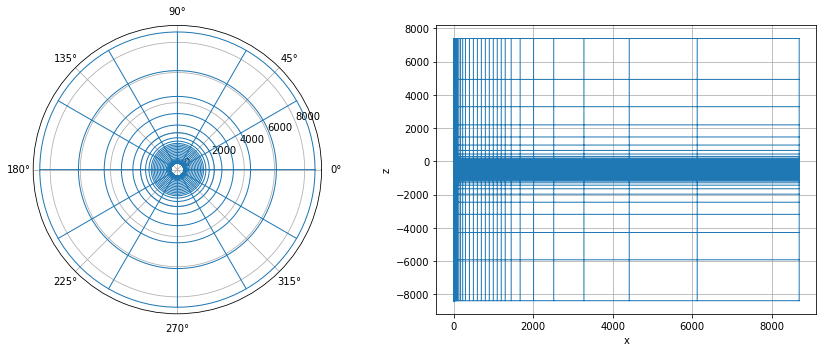

In [16]:
ax = meshGen.mesh.plotGrid()
# ax[0].set_rlim([50., 100.])
# ax[1].set_ylim([])

## Physical Properties

Now that we have a mesh and a model defined, we populate the mesh with physical properties

In [17]:
physprops_dict = {
    key: casingSim.model.PhysicalProperties(
        modelParameters=m, meshGenerator=meshGen
    )
    for key, m in model_dict.items() 
}


In [18]:
pp =physprops_dict["casing"]

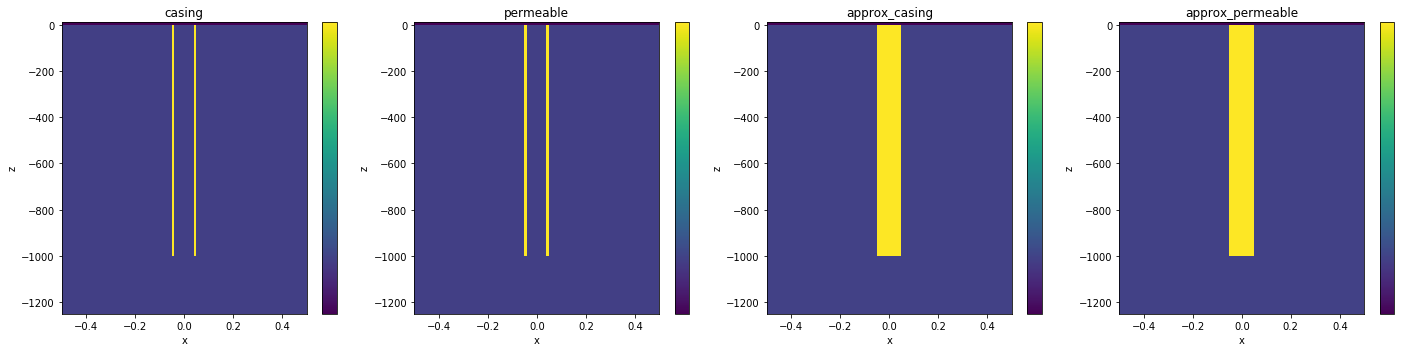

In [19]:
fig, ax = plt.subplots(1, len(model_names), figsize=(5*len(model_names), 5))

xlim = 0.5*np.r_[-1., 1.]
ylim = np.r_[-1.25*casing_l, 10.]

for m, a in zip(model_names, ax):
    physprops_dict[m].plot_sigma(ax=a, pcolorOpts={'norm':LogNorm()})
    a.set_xlim(xlim)
    a.set_ylim(ylim) 
    a.set_title(m)

plt.tight_layout()

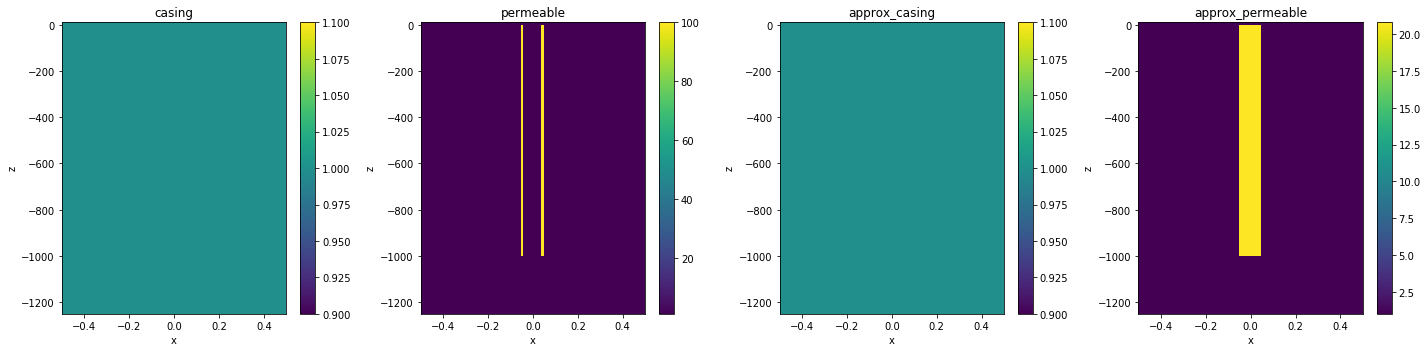

In [20]:
fig, ax = plt.subplots(1, len(model_names), figsize=(5*len(model_names), 5))

xlim = 0.5*np.r_[-1., 1.]
ylim = np.r_[-1.25*casing_l, 10.]

for m, a in zip(model_names, ax):
    physprops_dict[m].plot_mur(ax=a)
    a.set_xlim(xlim)
    a.set_ylim(ylim) 
    a.set_title(m)

plt.tight_layout()

## Survey

The source is a grounded source with one electrode at 1000m and the other electrode connected to the top of the casing. A wire connects them. Note that we will use H-J formulation t solve this problem, so the source is defined as current that goes through the faces of the mesh. 

In [21]:
src_theta = np.pi/2. + mesh.hy[0]/2.
model.src_a[1] = src_theta
model.src_b[1] = src_theta

In [22]:
top_src_a = model.src_a.copy()
top_src_a[2] = -mesh.hz.min()/2.

In [23]:
downhole_src_a = model.src_a.copy()
downhole_src_a[0] = 0.
downhole_src_a[2] = -950.

In [24]:
src_top = casingSim.sources.TopCasingSrc(
    directory=simDir, 
    modelParameters=model, 
    meshGenerator=meshGen,
    src_a=top_src_a,
    src_b=model.src_b,
    physics="TDEM",
    filename="top_casing",
)

src_downhole = casingSim.sources.DownHoleCasingSrc(
    directory=simDir, 
    modelParameters=model,
    meshGenerator=meshGen,
    src_a=downhole_src_a,
    src_b=model.src_b,
    physics="TDEM",
    filename="downhole",
)

sources = [src_top, src_downhole]
srcList = src_top.srcList + src_downhole.srcList

In [25]:
casingSimSrcList = casingSim.sources.SourceList(
    filename="sources.json",
    directory=simDir,
    sources = sources  
)

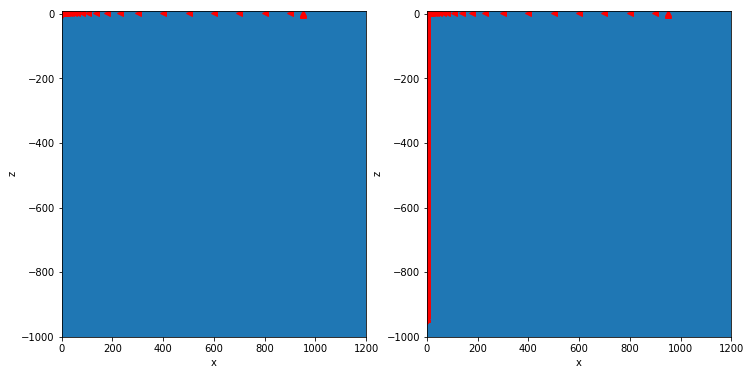

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for a, src in zip(ax, sources): 
    meshGen.mesh.plotGrid(slice='theta', ax=a)
    src.plot(ax=a)

    a.set_xlim([0., 1200])
    a.set_ylim([-1000., 10.])

## Simulation

In [27]:
save_files = False

In [28]:
model_dict

{'approx_casing': <casingSimulations.model.CasingInHalfspace at 0xd19951a90>,
 'approx_permeable': <casingSimulations.model.CasingInHalfspace at 0xd19951be0>,
 'casing': <casingSimulations.model.CasingInHalfspace at 0x10a07f9b0>,
 'permeable': <casingSimulations.model.CasingInHalfspace at 0xd1992fdd8>}

In [29]:
sim = casingSim.run.SimulationTDEM(
    directory=simDir, 
    formulation='j',
    meshGenerator=meshGen,
    modelParameters=model,
    srcList=casingSimSrcList, 
)

# sim.save()

In [30]:
if save_files:
    for key in model_names:
        model_dict[key].save()
    casingSimSrcList.save()
    meshGen.save()

In [31]:
m = "casing"
sim = casingSim.run.SimulationTDEM(
        modelParameters= simDir + "/" + m + ".json",
        meshGenerator=simDir + "/" +'MeshParameters.json',
        srcList=simDir + "/" +'sources.json',
        fields_filename=simDir + "/" +m + "_fields.npy"
    )

## load pre-computed results

In [32]:
# if use_downsampled_results:
#     f = "TDEM_fields_downsampled"
# else:
f = "TDEM_fields_response_1km"
    
# if not os.path.isdir(f):
#     download = Utils.download(
#         "https://storage.googleapis.com/simpeg/heagy_2018_emcyl/{}.tar.gz".format(f)
#     )  
#     tar = tarfile.open(download, "r:*")
#     tar.extractall()
#     tar.close()

load the results into memory

re-populate the fields object (this takes a couple minutes)

In [33]:
# model_names = model_names[:4]
# model_names += ["approx_permeable2"]

# model_names = ["casing", "permeable"] + model_names[3:]
# model_names += ["approx_permeable2"]
print(model_names)

['casing', 'permeable', 'approx_casing', 'approx_permeable']


In [34]:
%%time

# if rerun is False: 
    # recreate the fields object
fields_dict = {}

for key in model_names:
    
    if key not in fields_dict.keys():
#     t = time.time()
        print("loading {}".format(key))
        sol = np.load(f + os.path.sep + "{}_fields.npy".format(key))
        sim.prob.model = physprops_dict[key].model
        fields_dict[key] = sim.prob.fieldsPair(sim.meshGenerator.mesh, sim.survey)
        print("   populating fields")
        fields_dict[key][:, 'jSolution', :] = sol
#     print("... done. time: {:1.2f}s".format(time.time() - t))

loading casing
   populating fields
loading permeable
   populating fields
loading approx_casing
   populating fields
loading approx_permeable
   populating fields
CPU times: user 1min 26s, sys: 44.8 s, total: 2min 11s
Wall time: 2min 59s


In [35]:
sim_dict = {}
for key in model_names:
#     s = sim.copy()
#     s.modelParameters = model_dict[key]
#     s.
    sim_dict[key] = sim.copy()
    sim_dict[key].modelParameters = model_dict[key]
    sim_dict[key].srcList = sim.srcList

In [36]:
viewer = casingSim.FieldsViewer(
    model_keys=model_names, sim_dict=sim_dict, fields_dict=fields_dict, primary_key="casing"
)

In [37]:
viewer.widget_cross_section(
    defaults={
        "max_depth":1.5*model.casing_l,
        "min_depth":-10,
        "max_r":0.15,
        "theta_ind":3, 
        "view":"j"
    }
)

interactive(children=(FloatText(value=0.15, description='max_r'), FloatText(value=-10.0, description='min_depth'), FloatText(value=1500.0, description='max_depth'), FloatText(value=0.0, description='clim_min'), FloatText(value=0.0, description='clim_max'), ToggleButtons(description='model_key', options=('casing', 'permeable', 'approx_casing', 'approx_permeable', 'all'), value='casing'), ToggleButtons(description='view', index=3, options=('sigma', 'mur', 'e', 'j', 'dbdt', 'dhdt', 'charge', 'charge_density'), value='j'), ToggleButtons(description='prim_sec', options=('total', 'primary', 'secondary', 'percent'), value='total'), IntSlider(value=0, description='src_ind', max=1), IntSlider(value=3, description='theta_ind', max=11), IntSlider(value=0, description='time_ind', max=187), Checkbox(value=False, description='show_mesh'), Checkbox(value=False, description='use_aspect'), Checkbox(value=True, description='casing_outline'), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

In [39]:
from matplotlib import rcParams
rcParams['font.size'] = 14

In [40]:
viewer.primary = "casing"

In [41]:
viewer.widget_cross_section(
    defaults={
        "max_depth":1.5*model.casing_l,
        "min_depth":-10,
        "max_r":1.5*model.casing_l,
        "theta_ind":3,
        "view":"j"
    }, 
    figwidth=12
)

interactive(children=(FloatText(value=1500.0, description='max_r'), FloatText(value=-10.0, description='min_depth'), FloatText(value=1500.0, description='max_depth'), FloatText(value=0.0, description='clim_min'), FloatText(value=0.0, description='clim_max'), ToggleButtons(description='model_key', options=('casing', 'permeable', 'approx_casing', 'approx_permeable', 'all'), value='casing'), ToggleButtons(description='view', index=3, options=('sigma', 'mur', 'e', 'j', 'dbdt', 'dhdt', 'charge', 'charge_density'), value='j'), ToggleButtons(description='prim_sec', options=('total', 'primary', 'secondary', 'percent'), value='total'), IntSlider(value=0, description='src_ind', max=1), IntSlider(value=3, description='theta_ind', max=11), IntSlider(value=0, description='time_ind', max=187), Checkbox(value=False, description='show_mesh'), Checkbox(value=False, description='use_aspect'), Checkbox(value=True, description='casing_outline'), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

## Plan View 

In [42]:
viewer = casingSim.FieldsViewer(
    model_keys=model_names, sim_dict=sim_dict, fields_dict=fields_dict, primary_key="casing"
)

In [43]:
viewer.widget_depth_slice(
    fixed={"rotate": True, "figwidth":6}, 
    defaults={
        "max_r":1500, "z_ind":400, "time_ind":1, "view":"j", "model_key":"casing", 
        "use_aspect":True, "theta_shift":mesh.hy[0]/2, "k":10
    }
)

interactive(children=(FloatText(value=1500.0, description='max_r'), FloatText(value=0.0, description='clim_min'), FloatText(value=0.0, description='clim_max'), ToggleButtons(description='model_key', options=('casing', 'permeable', 'approx_casing', 'approx_permeable', 'all'), value='casing'), ToggleButtons(description='view', index=3, options=('sigma', 'mur', 'e', 'j', 'dbdt', 'dhdt', 'charge', 'charge_density'), value='j'), ToggleButtons(description='prim_sec', options=('total', 'primary', 'secondary', 'percent'), value='total'), IntSlider(value=400, description='z_ind', max=443), IntSlider(value=0, description='src_ind', max=1), IntSlider(value=1, description='time_ind', max=187), Checkbox(value=True, description='use_aspect'), IntSlider(value=10, description='k', max=50), FloatText(value=0.2617993877991494, description='theta_shift'), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

In [44]:
# @dask.delayed
def get_e_data(key, src_ind=0, xmin=5, xmax=1000, rx_times=np.logspace(-5, np.log10(5e-3), 20)):
    f = fields_dict[key]
    e = f[f.survey.srcList[src_ind], 'e', :]
    print('   fetched e')
    er = e[:mesh.vnF[0], :]
    del e
    
    e_tz_inds = (
        (mesh.gridFx[:, 0]>=xmin) & (mesh.gridFx[:, 0]<=xmax) & 
        (mesh.gridFx[:, 1] == mesh.vectorCCy[0]) & 
        (mesh.gridFx[:, 2] == -csz/2.)
    )

    x_inds = (mesh.vectorNx>=xmin) & (mesh.vectorNx<=xmax)
    rx_x = mesh.vectorNx[x_inds]
    
    time_inds = discretize.utils.closestPoints(f.survey.prob.timeMesh, rx_times, 'N')
    times = f.survey.prob.timeMesh.gridN[time_inds]
    del f
    
    e_data = (er[e_tz_inds, :])[:, time_inds]
    del er
    
    e_data = e_data.reshape(len(rx_x), len(times), order="F")
    
    return rx_x, times, e_data

In [45]:
# @dask.delayed
def get_dbdt_data(key, src_ind=0, xmin=5, xmax=1000, rx_times=np.logspace(-5, np.log10(5e-3), 20)):
    f = fields_dict[key]
    dbdt = f[f.survey.srcList[src_ind], 'dbdt', :]
    print('   fetched dbdt')
    dbdt = dbdt[mesh.vnE[0]:mesh.vnE[:2].sum(), :]
    
    dbdt_tz_inds = (
        (mesh.gridEy[:, 0]>=xmin) & (mesh.gridEy[:, 0]<=xmax) & 
        (mesh.gridEy[:, 1] == mesh.vectorCCy[0]) & 
        (mesh.gridEy[:, 2] == 0)
    )

    x_inds = (mesh.vectorNx>=xmin) & (mesh.vectorNx<=xmax)
    rx_x = mesh.vectorNx[x_inds]
    
    time_inds = discretize.utils.closestPoints(f.survey.prob.timeMesh, rx_times, 'N')
    times = f.survey.prob.timeMesh.gridN[time_inds]
    del f
    
    dbdt_data = (dbdt[dbdt_tz_inds, :])[:, time_inds]
    del dbdt
    
    dbdt_data = dbdt_data.reshape(len(rx_x), len(times), order="F")
    
    return rx_x, times, dbdt_data

In [46]:
# @dask.delayed
def get_dbzdt_data(key, src_ind=0, xmin=5, xmax=1000, rx_times=np.logspace(-5, np.log10(5e-3), 20)):
    f = fields_dict[key]
    dbdt = f[f.survey.srcList[src_ind], 'dbdt', :]
    print('   fetched dbzdt')
    dbdt = dbdt[mesh.vnE[:2].sum():, :]
    
    dbdt_tz_inds = (
        (mesh.gridEz[:, 0] >= xmin) & (mesh.gridEz[:, 0] <= xmax) & 
        (mesh.gridEz[:, 1] == mesh.vectorNy[0]) & 
        (mesh.gridEz[:, 2] == -csz/2)
    )

    x_inds = (mesh.vectorNx >= xmin) & (mesh.vectorNx <= xmax)
    rx_x = mesh.vectorNx[x_inds]
    
    time_inds = discretize.utils.closestPoints(f.survey.prob.timeMesh, rx_times, 'N')
    times = f.survey.prob.timeMesh.gridN[time_inds]
    del f
    
    dbdt_data = (dbdt[dbdt_tz_inds, :])[:, time_inds]
    del dbdt
    
    dbdt_data = dbdt_data.reshape(len(rx_x), len(times), order="F")
    
    return rx_x, times, dbdt_data

In [47]:
data_time = {}

for key in model_names:
    if key not in data_time.keys():
        x, t, data_time[key] = get_e_data(key, rx_times=fields_dict[key].survey.prob.timeMesh.gridN, src_ind=0)

   fetched e
   fetched e
   fetched e
   fetched e


In [48]:
dbdt_time = {}

for key in model_names:
    if key not in dbdt_time.keys():
        x, t, dbdt_time[key] = get_dbdt_data(key, rx_times=fields_dict[key].survey.prob.timeMesh.gridN, src_ind=0)

   fetched dbdt
   fetched dbdt
   fetched dbdt
   fetched dbdt


In [49]:
# dbzdt_time = {}

# for key in model_names:
#     if key not in dbzdt_time.keys():
#         xz, tz, dbzdt_time[key] = get_dbzdt_data(key, rx_times=fields_dict[key].survey.prob.timeMesh.gridN, src_ind=0)

In [50]:
from matplotlib import colors
from matplotlib import cm as cmap

In [51]:
rx_times = np.logspace(-5, np.log10(5e-3), 20)
# rx_times = rx_times - rx_times[0] + fields_dict["casing"].survey.prob.timeMesh.gridN[1]
time_inds = discretize.utils.closestPoints(fields_dict["casing"].survey.prob.timeMesh, rx_times, 'N')
times = fields_dict["casing"].survey.prob.timeMesh.gridN[time_inds]
print(times)

[1.00e-05 1.40e-05 1.90e-05 3.00e-05 4.00e-05 5.00e-05 7.00e-05 1.00e-04
 1.40e-04 1.90e-04 2.60e-04 3.80e-04 5.00e-04 7.10e-04 9.80e-04 1.32e-03
 1.92e-03 2.62e-03 3.62e-03 5.02e-03]


In [118]:
cm = plt.get_cmap('magma')
key = "casing"
c_norm = colors.LogNorm(vmin=times.min(), vmax=times.max()*6)
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

In [53]:
data_time["casing"].shape
x.shape

(23,)

In [54]:
# fig, ax = plt.subplots(1, 1)
# for key, ls in zip(["casing", "permeable"], ['-', 'o', 'd']):
#     e_data = data_time[key][:, time_inds]
    
#     for i, time in enumerate(times):
#         color=scalar_map.to_rgba(time)
#         ax.semilogy(x, np.absolute(e_data[:, i]), ls, color=color, markersize="2")
# # plt.semilogy(-e_data, '--')

In [55]:
# fig, ax = plt.subplots(1, 1)
# x, t, e = e_data[key]

# for i, time in enumerate(t):
#     color=scalar_map.to_rgba(time)
#     ax.semilogy(x, (e_data["permeable"][2][:, i] - e_data["casing"][2][:, i]), '-', color=color, markersize="2")
#     ax.semilogy(x, -(e_data["permeable"][2][:, i] - e_data["casing"][2][:, i]), '--', color=color, markersize="2")

#     # plt.semilogy(-e_data, '--')

In [117]:
from string import ascii_lowercase
from matplotlib import rcParams

rcParams['font.size'] = 14

In [57]:
def plot_data(x, data, color, ax, plot_sign=False, ls='-', lw=1, ms=2, plot_type="semilogy", label=None):
    
    if plot_sign is True and plot_type == "semilogy":
        pos = data >= 0   
        ax.semilogy(x[pos], data[pos], '-', color=color, label=label, lw=lw)
        ax.semilogy(x[~pos], -data[~pos], '--', color=color, label=label, lw=lw)
    else:
        getattr(ax, plot_type)(x, np.absolute(data), ls, color=color, label=label, lw=lw, ms=ms)

In [58]:
print(model_dict["casing"].src_a)
print(np.pi/2 + mesh.hy[0]/2)

[0.05       1.83259571 0.        ]
1.832595714594046


In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(6, 10))



for ii, time in enumerate(times):
    i = time_inds[ii]
    color=scalar_map.to_rgba(time)
    
    plot_data(x, data_time["background"][:, i], color, ax[0], ls='--') #, label="background" if ii ==0 else None) # casing
    plot_data(x, data_time["casing"][:, i], color, ax[1], ls='-') #, label="casing" if ii == 0 else None) # casing

    plot_data(x, data_time["casing"][:, i]-data_time["background"][:, i], color, ax[2], ls='-') # casing

#     plot_data(x, (data_time["casing"][:, i]-data_time["background"][:, i])/np.absolute(data_time["background"][:, i])*100, color, ax[2], plot_type="plot") # permeable

    ax[2].set_ylim([0, 100])


for i, a in enumerate(ax):
#     if i < 2:
#         a.set_ylim([1e-7, 1e-1])
    a.grid(which="both", alpha=0.4, lw=0.5)
    a.set_title('({})'.format(ascii_lowercase[i]))
    a.set_ylim([1e-9, 9e-2])
    
    if i < len(ax)-1:
        a.set_xticklabels(['']*len(a.get_xticklabels()))
        
    if i in [0, 1]: 
        a.set_ylabel('electric field, E$_r$ (V/m)')
#         a.legend()
    else: 
        a.set_ylabel('difference, E$_r$ (V/m)')
        
# ax[0].legend()


plt.tight_layout()
cbar_ax = fig.add_axes([0.25, -0.02, 0.65, 0.01])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (s)')
    #     plot_semilogy(x, , color, ax[1], ls='.') # permeable
    
fig.savefig('../figures/surface_e_fields_casing', bbox_inches="tight", dpi=200)

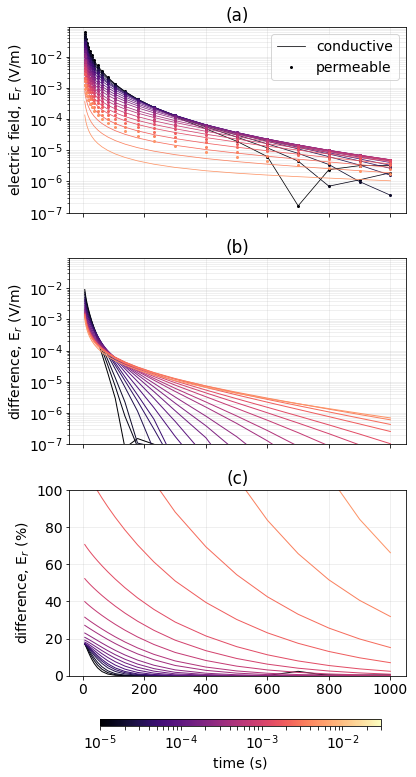

In [68]:
fig, ax = plt.subplots(3, 1, figsize=(6, 10))


for ii, time in enumerate(times):
    i = time_inds[ii]
    color=scalar_map.to_rgba(time)
    
    plot_data(x, data_time["casing"][:, i], color, ax[0], ls='-', lw=0.75, label="conductive" if ii ==0 else None)
    plot_data(x, data_time["permeable"][:, i], color, ax[0], ls='o', label="permeable" if ii == 0 else None) 

    plot_data(x, data_time["permeable"][:, i]-data_time["casing"][:, i], color, ax[1], ls='-') 
    plot_data(x, (data_time["permeable"][:, i]-data_time["casing"][:, i])/data_time["casing"][:, i]*100, color, ax[2], ls='-', plot_type="plot") 

#     plot_data(x, (data_time["casing"][:, i]-data_time["casing"][:, i])/np.absolute(data_time["casing"][:, i])*100, color, ax[2], plot_type="plot") # permeable

    ax[2].set_ylim([0, 100])


for i, a in enumerate(ax):
#     if i < 2:
#         a.set_ylim([1e-7, 1e-1])
    a.grid(which="both", alpha=0.4, lw=0.5)
    a.set_title('({})'.format(ascii_lowercase[i]))
    if i < 2:
        a.set_ylim([1e-7, 9e-2])
    
    if i < len(ax)-1:
        a.set_xticklabels(['']*len(a.get_xticklabels()))
         
ax[0].legend()
ax[0].set_ylabel('electric field, E$_r$ (V/m)')
ax[1].set_ylabel('difference, E$_r$ (V/m)')
ax[2].set_ylabel('difference, E$_r$ (%)')

plt.tight_layout()
cbar_ax = fig.add_axes([0.25, -0.02, 0.65, 0.01])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (s)')
    #     plot_semilogy(x, , color, ax[1], ls='.') # permeable
    
fig.savefig('../figures/surface_e_fields_permeable_downhole', bbox_inches="tight", dpi=200)

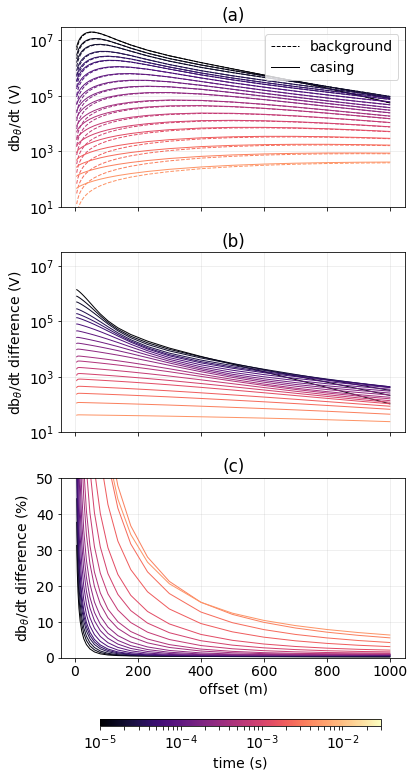

In [64]:
fig, ax = plt.subplots(3, 1, figsize=(6, 10))

for ii, time in enumerate(times):
    i = time_inds[ii]
    color=scalar_map.to_rgba(time)
    
    plot_data(x, dbdt_time["background"][:, i], color, ax[0], ls='--', label="background" if ii ==0 else None) # casing
    plot_data(x, dbdt_time["casing"][:, i], color, ax[0], ls='-', label="casing" if ii == 0 else None) # casing

    plot_data(x, dbdt_time["casing"][:, i]-dbdt_time["background"][:, i], color, ax[1], ls='-') # casing
    plot_data(x, np.absolute(dbdt_time["casing"][:, i]-dbdt_time["background"][:, i])/dbdt_time["background"][:, i]*100, color, ax[2], ls='-', plot_type="plot") # casing

#     plot_data(x, (data_time["casing"][:, i]-data_time["background"][:, i])/np.absolute(data_time["background"][:, i])*100, color, ax[2], plot_type="plot") # permeable

    ax[2].set_ylim([0, 100])


for i, a in enumerate(ax):
#     if i < 2:
#         a.set_ylim([1e-7, 1e-1])
    a.grid(which="both", alpha=0.4, lw=0.5)
    a.set_title('({})'.format(ascii_lowercase[i]))
    a.set_ylim([1e-9, 9e-2])
    
    if i < len(ax)-1:
        a.set_xticklabels(['']*len(a.get_xticklabels()))
        a.set_ylim([1e1, 3e7])
    else:
        a.set_ylim([0, 50])
        a.set_xlabel('offset (m)')
    
        
ax[0].set_ylabel('db$_{\\theta}$/dt (V)')
ax[1].set_ylabel('db$_{\\theta}$/dt difference (V)')
ax[2].set_ylabel('db$_{\\theta}$/dt difference (%)')

ax[0].legend()


plt.tight_layout()
cbar_ax = fig.add_axes([0.25, -0.02, 0.65, 0.01])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (s)')
    #     plot_semilogy(x, , color, ax[1], ls='.') # permeable
    
fig.savefig('../figures/surface_dbdt_fields_casing', bbox_inches="tight", dpi=200)

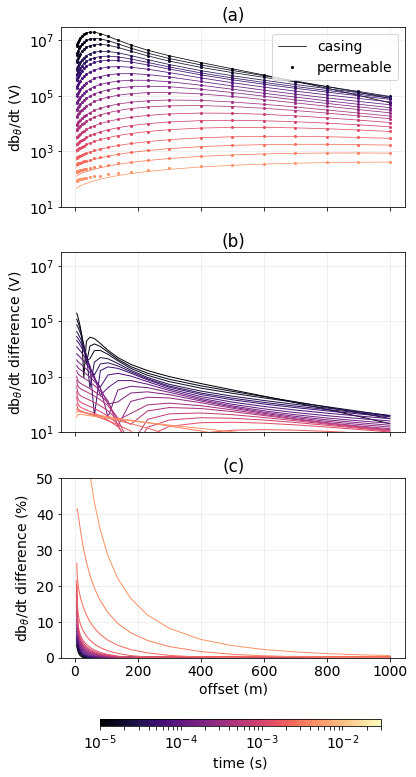

In [65]:
fig, ax = plt.subplots(3, 1, figsize=(6, 10))

for ii, time in enumerate(times):
    i = time_inds[ii]
    color=scalar_map.to_rgba(time)
    
    plot_data(x, dbdt_time["casing"][:, i], color, ax[0], ls='-', lw=0.75, label="casing" if ii ==0 else None) # casing
    plot_data(x, dbdt_time["permeable"][:, i], color, ax[0], ls='o', label="permeable" if ii == 0 else None) # casing

    plot_data(x, dbdt_time["permeable"][:, i]-dbdt_time["casing"][:, i], color, ax[1], ls='-') # casing
    plot_data(x, np.absolute(dbdt_time["permeable"][:, i]-dbdt_time["casing"][:, i])/dbdt_time["casing"][:, i]*100, color, ax[2], ls='-', plot_type="plot") # casing

#     plot_data(x, (data_time["permeable"][:, i]-data_time["casing"][:, i])/np.absolute(data_time["casing"][:, i])*100, color, ax[2], plot_type="plot") # permeable

    ax[2].set_ylim([0, 100])


for i, a in enumerate(ax):
#     if i < 2:
#         a.set_ylim([1e-7, 1e-1])
    a.grid(which="both", alpha=0.4, lw=0.5)
    a.set_title('({})'.format(ascii_lowercase[i]))
    a.set_ylim([1e-9, 9e-2])
    
    if i < len(ax)-1:
        a.set_xticklabels(['']*len(a.get_xticklabels()))
        a.set_ylim([1e1, 3e7])
    else:
        a.set_ylim([0, 50])
        a.set_xlabel('offset (m)')
    
        
ax[0].set_ylabel('db$_{\\theta}$/dt (V)')
ax[1].set_ylabel('db$_{\\theta}$/dt difference (V)')
ax[2].set_ylabel('db$_{\\theta}$/dt difference (%)')

ax[0].legend()


plt.tight_layout()
cbar_ax = fig.add_axes([0.25, -0.02, 0.65, 0.01])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (s)')
    #     plot_semilogy(x, , color, ax[1], ls='.') # permeable
    
fig.savefig('../figures/surface_dbdt_fields_permeable', bbox_inches="tight", dpi=200)

KeyError: 'background'

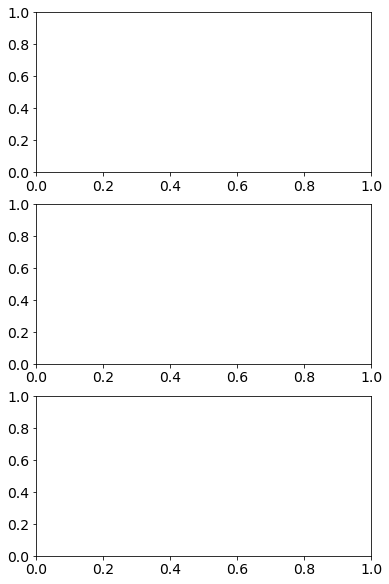

In [59]:
fig, ax = plt.subplots(3, 1, figsize=(6, 10))

for ii, time in enumerate(times):
    i = time_inds[ii]
    color=scalar_map.to_rgba(time)
    
    plot_data(x, dbdt_time["background"][:, i], color, ax[0], ls='o', label="background" if ii ==0 else None) # casing
    plot_data(x, dbdt_time["casing"][:, i], color, ax[0], label="casing" if ii == 0 else None) # casing

    plot_data(x, dbdt_time["casing"][:, i]-dbdt_time["background"][:, i], color, ax[1]) # casing
    plot_data(x, (dbdt_time["casing"][:, i]-dbdt_time["background"][:, i])/(dbdt_time["background"][:, i]), color, ax[2], plot_type="plot") # casing

#     plot_data(x, (data_time["casing"][:, i]-data_time["background"][:, i])/np.absolute(data_time["background"][:, i])*100, color, ax[2], plot_type="plot") # permeable

#     ax[2].set_ylim([0, 100])


for i, a in enumerate(ax):
#     if i < 2:
#         a.set_ylim([1e-7, 1e-1])
    a.grid(which="both", alpha=0.4, lw=0.5)
    a.set_title('({})'.format(ascii_lowercase[i]))
#     a.set_ylim([3e-9, 9e-2])
    
    if i < len(ax)-1:
        a.set_xticklabels(['']*len(a.get_xticklabels()))
        
    if i in [0, 1]: 
        a.set_ylabel('db$_{\\theta}$/dt, (V)')
        a.legend()
    else: 
        a.set_ylabel('db$_{\\theta}$/dt difference (V)')
        
# ax[0].legend()


plt.tight_layout()
cbar_ax = fig.add_axes([0.25, -0.02, 0.65, 0.01])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (s)')
    #     plot_semilogy(x, , color, ax[1], ls='.') # permeable
    
# fig.savefig('../figures/surface_e_fields_casing', bbox_inches="tight", dpi=200)

In [125]:
model_dict["approx_permeable"].mur_casing * model_dict["approx_permeable"].casing_b

1.04

In [126]:
model_dict["permeable"].mur_casing * model_dict["permeable"].casing_t

1.0

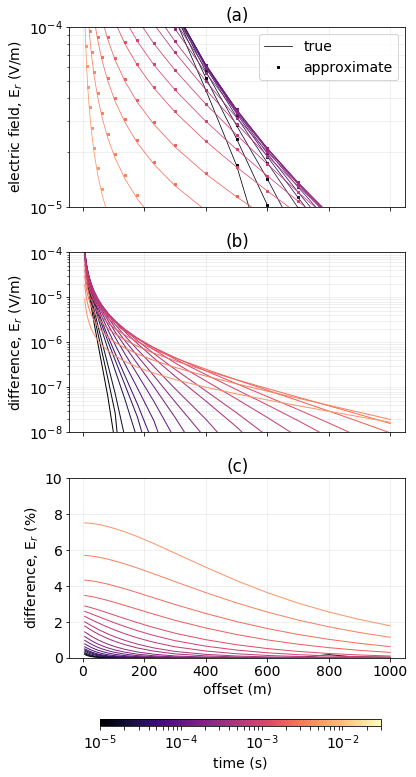

In [150]:
fig, ax = plt.subplots(3, 1, figsize=(6, 10))

model_key="casing"

for ii, time in enumerate(times):
    i = time_inds[ii]
    color=scalar_map.to_rgba(time)
    
    plot_data(x, data_time[model_key][:, i], color, ax[0], lw=0.75, label="true" if ii == 0 else None) # casing
    plot_data(x, data_time["approx_{}".format(model_key)][:, i], color, ax[0], ls='s', label="approximate" if ii ==0 else None) # casing

    plot_data(x, data_time["approx_{}".format(model_key)][:, i]-data_time[model_key][:, i], color, ax[1]) # casing

    plot_data(x, (data_time["approx_{}".format(model_key)][:, i]-data_time[model_key][:, i])/np.absolute(data_time[model_key][:, i])*100, color, ax[2], plot_type="plot") # permeable

    if model_key == "casing":
        ax[0].set_ylim([1e-7, 1e-1])
#         ax[0].set_ylim([1e-5, 1e-4])
        ax[1].set_ylim([1e-8, 1e-4])
        ax[2].set_ylim([0, 10])
    elif model_key == "permeable":
        ax[0].set_ylim([1e-7, 1e-1])
        ax[1].set_ylim([1e-7, 1e-3])
        ax[2].set_ylim([0, 20])


for i, a in enumerate(ax):
#     if i < 2:
#         a.set_ylim([1e-7, 1e-1])
    a.grid(which="both", alpha=0.4, lw=0.5)
    a.set_title('({})'.format(ascii_lowercase[i]))
    
    if i < len(ax)-1:
        a.set_xticklabels(['']*len(a.get_xticklabels()))
        if i == 0: 
            a.set_ylabel('electric field, E$_r$ (V/m)')
        else: 
            a.set_ylabel('difference, E$_r$ (V/m)')
    else:
        a.set_xlabel('offset (m)')
        a.set_ylabel('difference, E$_r$ (%)')
ax[0].legend()


plt.tight_layout()
cbar_ax = fig.add_axes([0.25, -0.02, 0.65, 0.01])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (s)')

fig.savefig('../figures/approx-{}-data'.format(model_key), dpi=250, bbox_inches="tight")

    #     plot_semilogy(x, , color, ax[1], ls='.') # permeable

(1799999.9999999993, 1799999.9999999993)

# Plot Current density

In [ ]:
# fields_dict2 = {}
# sim_dict2 = {}

# for key, sim in sim_dict.items():
#     sim_dict2[key] = sim.copy()
#     sim_dict2[key]._prob = sim._prob
#     sim_dict2[key]._survey = sim._survey

# if use_downsampled_results:
#     f = "TDEM_fields_publication"
#     if not os.path.isdir(f):
#         download = Utils.download(
#             "https://storage.googleapis.com/simpeg/heagy_2018_emcyl/{}.tar.gz".format(f)
#         )  
#         tar = tarfile.open(download, "r:*")
#         tar.extractall()
#         tar.close()
        
#     jSolution = np.load(f + os.path.sep + 'fields.npy')
#     jSolution_background = np.load(f + os.path.sep + 'fields_background.npy')
    
#     times = np.load(f + os.path.sep + 'times.npy')    
#     timesteps = np.hstack(np.diff(times))
    
#     plt_times = np.arange(0, len(times))
    
#     for sim in sim_dict2.values():
#         sim.prob.timeSteps = timesteps

#     # recreate the fields object
#     for key, sim in sim_dict2.items():
#         sim.prob.model = physprops_dict[key].model
#         fields_dict2[key] = sim.prob.fieldsPair(sim.meshGenerator.mesh, sim.survey)    
        
#     fields_dict2["casing"][:,'jSolution',:] = jSolution
#     fields_dict2["background"][:,'jSolution',:] = jSolution_background
        
# else:
#     plt_times = [0, 10, 28, 73, 118, 136]
#     fields_dict2 = fields_dict

In [60]:
from matplotlib import rcParams
from matplotlib import gridspec
# rcParams['font.size'] = 1

In [61]:
viewer2 = casingSim.FieldsViewer(
    model_keys=model_names, sim_dict=sim_dict, fields_dict=fields_dict, primary_key="casing"
)

In [62]:
plt_times = [0, 10, 28, 73, 118, 136]
# plt_times = [0, 10, 54, 110, 164, 185, 236]
t[plt_times]

array([0.000e+00, 1.000e-05, 1.000e-04, 1.010e-03, 5.020e-03, 1.002e-02])

In [63]:
len(t)

188

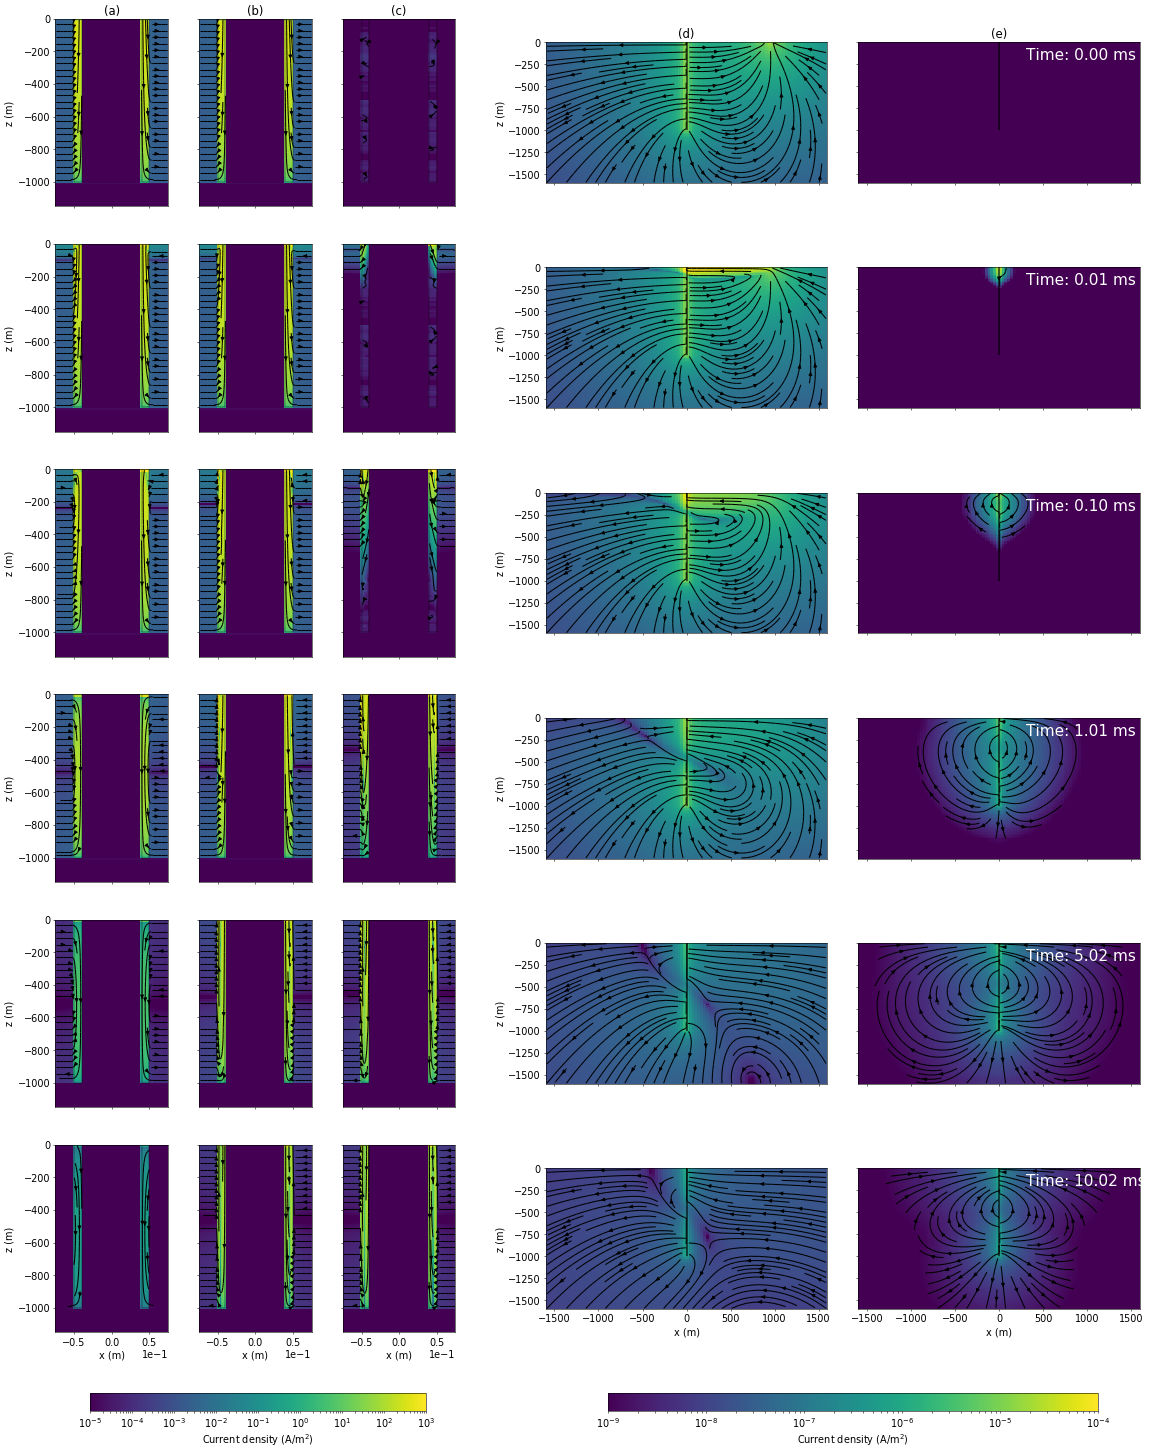

In [61]:
# clim_casing = np.r_[1e-5, 1e3]
# clim_formation = np.r_[1e-9, 1e-4]

# zlim_casing = np.r_[-1150, 0]
# max_r_casing = 0.075

# x_extent_formation = 1600
# xlim = x_extent_formation*np.r_[-1., 1.]

# x_ticks = [0, -500, -1000, -1500]


# fig = plt.figure(figsize=(28, 5.8*len(plt_times)), dpi=50) 
# # fig.subplots_adjust(bottom=0.8)

# gs = gridspec.GridSpec(len(plt_times), 6, width_ratios=[1, 1, 1, 0.25, 2.5, 2.5]) 
    
# ax = [plt.subplot(gs[i]) for i in range(len(plt_times)*6)]

# for i, tind in enumerate(plt_times):
    
#     ax0 = ax[i*6]
#     ax1 = ax[i*6 + 1]
#     ax2 = ax[i*6 + 2]
#     ax3 = ax[i*6 + 4]
#     ax4 = ax[i*6 + 5]
    
#     ax[i*6 + 3].set_axis_off() # hack to get the spacing I want between the casing and formation plots
    
#     # plot the casing 
#     out_casing = viewer2.plot_cross_section(
#         ax=ax0, clim=clim_casing, zlim=zlim_casing,
#         xlim=max_r_casing*np.r_[-1., 1.],
#         view='j', theta_ind=3, time_ind=tind, 
#         model_key='casing', show_cb=False, casing_outline=True
#     )
#     ax0.set_ylim(zlim_casing)
#     ax0.set_ylabel('z (m)')
    
#     out_casing = viewer2.plot_cross_section(
#         ax=ax1, clim=clim_casing, zlim=zlim_casing,
#         xlim=max_r_casing*np.r_[-1., 1.],
#         view='j', theta_ind=3, time_ind=tind, 
#         model_key='permeable', show_cb=False, casing_outline=True
#     )
#     ax0.set_ylim(zlim_casing)
#     ax0.set_ylabel('z (m)')
    
#     out_casing_diff = viewer2.plot_cross_section(
#         ax=ax2, clim=clim_casing, zlim=zlim_casing,
#         xlim=max_r_casing*np.r_[-1., 1.],
#         view='j', theta_ind=3, time_ind=tind, 
#         model_key='permeable', show_cb=False, casing_outline=True, prim_sec="secondary"
#     )
#     ax1.set_ylim(zlim_casing)
#     ax1.set_ylabel('z (m)')
    
#     # currents in the formation
#     out_formation = viewer2.plot_cross_section(
#         ax=ax3, clim=clim_formation, 
#         zlim=np.r_[-x_extent_formation, 0],
#         xlim=xlim, view='j', theta_ind=3, time_ind=tind, 
#         model_key='permeable', show_cb=False, use_aspect=True,
#         casing_outline=True
#     )
    
#     out_formation2 = viewer2.plot_cross_section(
#         ax=ax4, clim=clim_formation, 
#         zlim=np.r_[-x_extent_formation, 0],
#         xlim=xlim, view='j', theta_ind=3, time_ind=tind, 
#         model_key='permeable', show_cb=False, use_aspect=True,
#         casing_outline=True, prim_sec="secondary"
#     )
    
#     ax4.text(300, -200, "Time: {:.2f} ms".format(t[tind]*1e3), color='w', fontsize=22)

# #     gs.tight_layout(fig)
# #     plt.tight_layout()
#     # zoomed in plot
#     # currents in the formation
    
# #     ax3.set_yticks(z_ticks)
    
#     for a in [ax0, ax1, ax2, ax3, ax4]:
#         a.set_title('')
#         if a not in [ax0, ax1, ax2]: 
#             a.set_aspect(1)
# #         else:
# #             a.set_aspect(1e-4)
            
#         if tind == plt_times[-1]:
#             a.set_xlabel('x (m)')
#             if a in [ax0, ax1, ax2]:
#                 a.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#         else: 
#             a.set_xticklabels(['']*len(a.get_xticklabels()))
#             a.set_xlabel('')
        
#         if a in [ax1, ax2, ax4]:
#             a.set_ylabel('')
#             a.set_yticklabels(['']*len(a.get_yticklabels()))
    
#         else:
#             a.set_ylabel('z (m)')
        
            
#     if tind == 0:
#         [a.set_title("({})".format(ascii_lowercase[j])) for j, a in enumerate([ax0, ax1, ax2, ax3, ax4])]
        
# # gs.tight_layout(fig)

# # plt.tight_layout()

# cbar_ax = fig.add_axes([0.15, 0.08, 0.24, 0.01])
# cb = plt.colorbar(out_casing[0], cbar_ax, orientation='horizontal')
# cb.set_label('Current density (A/m$^2$)')

# cbar_ax2 = fig.add_axes([0.52, 0.08, 0.35, 0.01])
# cb2 = plt.colorbar(out_formation[0], cbar_ax2, orientation='horizontal')
# cb2.set_label('Current density (A/m$^2$)')
# # cb2.set_ticks([1e-8, 1e2])
# # cb2.update_ticks()

# plt.show()

In [ ]:
fig.savefig('../figures/tdem_permeable_currents', bbox_inches='tight', dpi=300)
# fig.savefig('../arxiv-figures/tdem_currents', bbox_inches='tight', dpi=150)

In [62]:
viewer2.primary_key = "casing"

In [63]:
model_names

['casing', 'permeable', 'approx_casing', 'approx_permeable']

In [66]:
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)

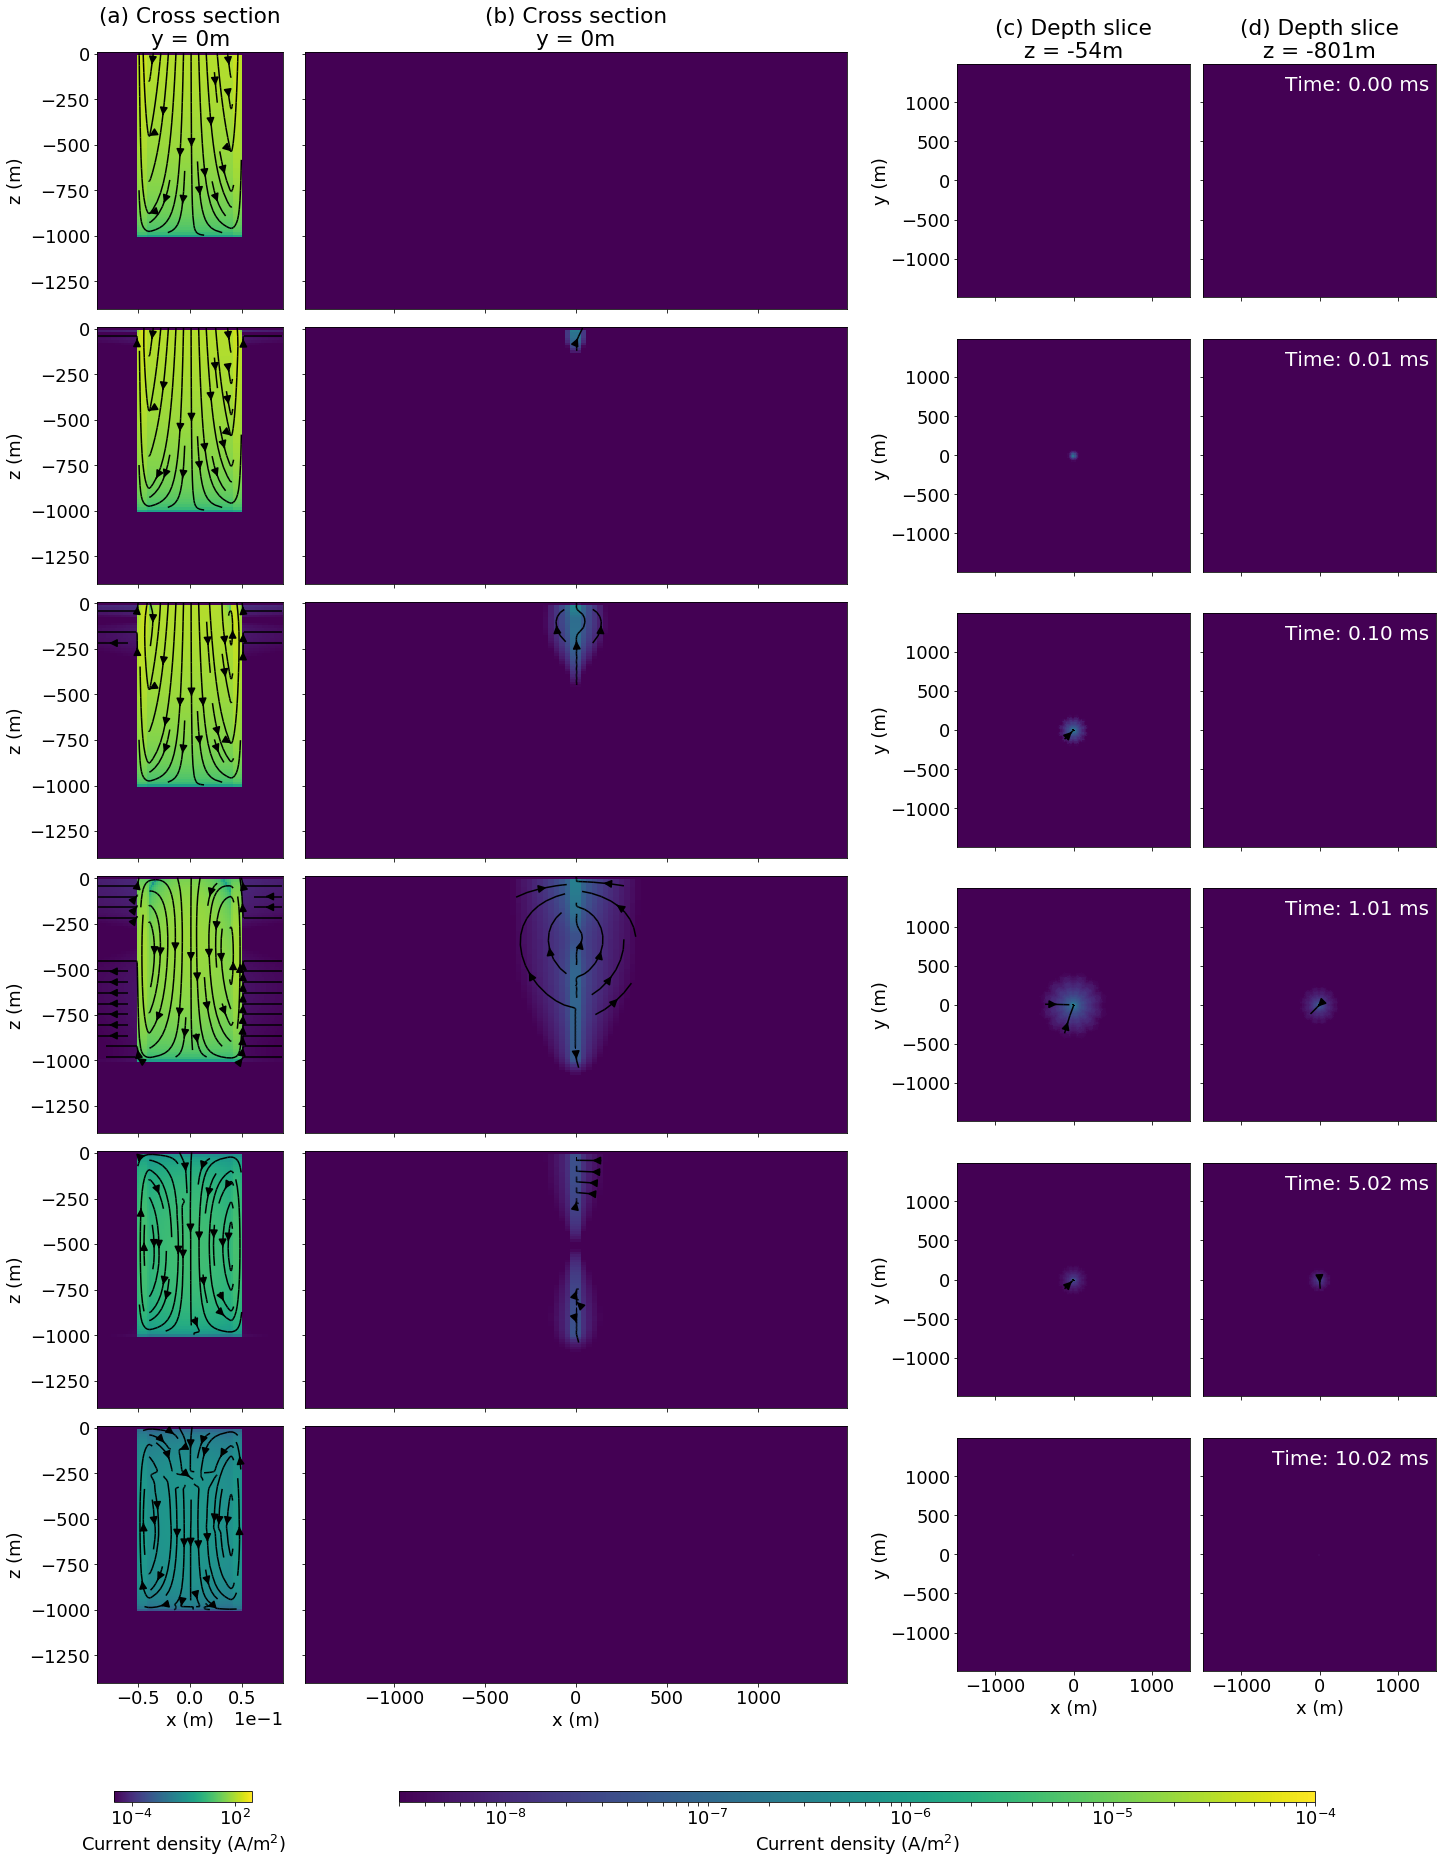

In [64]:
rcParams['font.size'] = 18
# rcParams['axes.titlepad'] = 0.5

src_ind = 0

clim_max = 1e-4 
clim_min = 3e-9
clim = np.r_[clim_min, clim_max]

# clim_casing = np.r_[1e-5, 1e3]
# clim_formation = np.r_[1e-9, 1e-4]

clim_max_casing = 1e3
clim_min_casing = 1e-5
clim_casing = np.r_[clim_min_casing, clim_max_casing]

max_depth = 1.4*casing_l
max_r_casing = 0.09
top=10.,

xlim = 1490.*np.r_[-1., 1.]

zinds = [400, 101]

x_ticks = [0, -500, -1000, -1500]
stream_opts={"arrowsize":1.6, "color":"k", "density":0.85}

model_key = "approx_casing"
prim_sec = "secondary"

# fig, ax = plt.subplots(4, len(plt_times), figsize )

fig = plt.figure(figsize=(24, 5*len(plt_times))) 
# fig.subplots_adjust(bottom=0.8)

gs = gridspec.GridSpec(len(plt_times), 5, width_ratios=[1.6, 4.8, 0.65, 2, 2], wspace=0.05, hspace=0.07) 
ax = [plt.subplot(gs[i]) for i in range(len(plt_times)*5)]

for i, tind in enumerate(plt_times):
    
    ax0 = ax[i*5 + 1]
    ax1 = ax[i*5 + 3]
    ax2 = ax[i*5 + 4]
    ax3 = ax[i*5]
    
    ax[i*5 + 2].set_axis_off() # hack to get the spacing I want between the casing and formation plots
    
    if model_key == "background":
        ax3.set_axis_off()
    
    # currents in the formation
    out = viewer2.plot_cross_section(
        ax=ax0, clim=clim, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='j', theta_ind=3, time_ind=tind, 
        model_key=model_key, show_cb=False, use_aspect=True,
        stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
    )
        
    
    # plot depth slice above
    for a, z_ind in zip([ax1, ax2], zinds):
        out = viewer2.plot_depth_slice(
            xlim=xlim, ylim=xlim, clim=clim,
            ax=a, z_ind=z_ind, model_key=model_key, view='j',
            show_cb=False, time_ind=tind, rotate=True, theta_shift=mesh.hy[0]/2,
            stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
        )
    
    ax2.text(1400, 1150, "Time: {:.2f} ms".format(sim.prob.times[tind]*1e3), color='w', fontsize=20, ha="right")

    
    # zoomed in plot
    # currents in the formation
    
    if not model_key == "background":
        out_casing = viewer2.plot_cross_section(
            ax=ax3, clim=clim_casing, zlim=np.r_[-max_depth, top],
            xlim=max_r_casing*np.r_[-1, 1.],
            view='j', theta_ind=3, time_ind=tind, 
            model_key=model_key, show_cb=False,
            stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
        )
        ax3.set_ylim(np.r_[-max_depth, top])
        ax3.set_ylabel('z (m)')
#     ax3.set_yticks(z_ticks)
    
    for a in [ax0, ax1, ax2, ax3]:
        a.set_title('')
        if a != ax3: 
            a.set_aspect(1)
            
        if tind == plt_times[-1]:
            a.set_xlabel('x (m)')
            if a == ax3:
                a.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        else: 
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            a.set_xlabel('')
        
        if a in [ax2, ax0]:
            if a == ax0 and model_key == "background":
                a.set_ylabel('z (m)')
            else: 
                a.set_ylabel('')
                a.set_yticklabels(['']*len(a.get_yticklabels()))
        
            
        if a == ax1:
            a.set_ylabel('y (m)', labelpad=0.001)
        
            
    if tind == 0:
        if model_key != "background":
            ax0.set_title('(b) Cross section\ny = 0m')
            ax1.set_title('(c) Depth slice\nz = {:1.0f}m'.format(sim.prob.mesh.vectorCCz[zinds[0]]))
            ax2.set_title('(d) Depth slice\nz = {:1.0f}m'.format(sim.prob.mesh.vectorCCz[zinds[1]])) 
            ax3.set_title('(a) Cross section\ny = 0m')
        else:
            ax0.set_title('(a) Cross section\ny = 0m')
            ax1.set_title('(b) Depth slice\nz = {:1.0f}m'.format(sim.prob.mesh.vectorCCz[zinds[0]]))
            ax2.set_title('(c) Depth slice\nz = {:1.0f}m'.format(sim.prob.mesh.vectorCCz[zinds[1]]))
            ax3.set_title('')
#             ax3.set_title('(a) Cross section\ny = 0m\n')

# gs.tight_layout(fig, pad=0.1)
# plt.tight_layout()

cbar_ax = fig.add_axes([0.30, 0.07, 0.53, 0.005])
cb = plt.colorbar(out[0], cbar_ax, orientation='horizontal')
cb.set_label('Current density (A/m$^2$)')

if model_key != "background":
    cbar_ax2 = fig.add_axes([0.135, 0.07, 0.08, 0.005])
    cb2 = plt.colorbar(out_casing[0], cbar_ax2, orientation='horizontal')
    cb2.set_label('Current density (A/m$^2$)')
    cb2.set_ticks([1e1*clim_min_casing, 1e2])
    cb2.update_ticks()

plt.show()

In [ ]:
fig.savefig('../figures/tdem-{}-{}-currents-downhole'.format(model_key, prim_sec), bbox_inches="tight", dpi=250)

In [ ]:
s = sim_dict["casing"]

In [ ]:
s.srcList.sources[1].src_a

In [91]:
model.casing_b

0.05

In [144]:
mod = model.copy()
mod.casing_d = model.casing_b
mod.casing_t = model.casing_b

print(mod.casing_a, mod.casing_b)
print(model.casing_a, model.casing_b)

0.0 0.05
0.04000000000000001 0.05


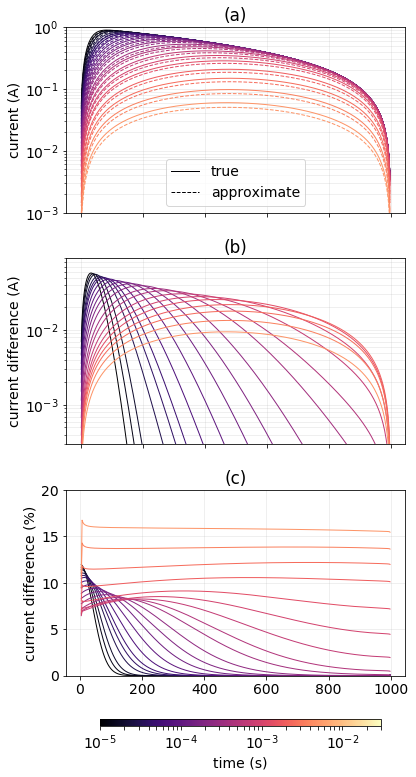

In [149]:
rcParams['font.size'] = 14
fig, ax = plt.subplots(3, 1, figsize=(6, 10))


key1 = "permeable"
key2 = "approx_{}".format(key1)

src1 = sim_dict[key1].srcList.srcList[0]
src2 = sim_dict[key2].srcList.srcList[0]

for ii, time in enumerate(times):
    i = time_inds[ii]
    color=scalar_map.to_rgba(time)

    z_currents, iz1 = casingSim.casing_currents(fields_dict[key1][src1, 'j', i], mesh, mod)["z"]
    z_currents, iz2 = casingSim.casing_currents(fields_dict[key2][src2, 'j', i], mesh, mod)["z"]
    
#     z_charges, charges1 = casingSim.casing_charges(fields_dict[key1][src1, 'charge', i], mesh, mod)
#     z_charges, charges2 = casingSim.casing_charges(fields_dict[key2][src2, 'charge', i], mesh, mod)
    
    # currents
    plot_data(-z_currents, iz1, color, ax[0], ls='-', label="true" if ii ==0 else None) # casing
    plot_data(-z_currents, iz2, color, ax[0], ls='--', label="approximate" if ii == 0 else None) # casing
    
    plot_data(-z_currents, iz2 - iz1, color, ax[1], ls='-') # casing
    plot_data(-z_currents[:-1], (iz2[:-1] - iz1[:-1])/iz1[:-1]*100, color, ax[2], ls='-', plot_type="plot") # casing

#     # charges
#     plot_data(-z_charges, charges1, color, ax[0, 1], ls='-', label="true" if ii ==0 else None) # casing
#     plot_data(-z_charges, charges2, color, ax[0, 1], ls='--', label="approximate" if ii == 0 else None) # casing
    
#     plot_data(-z_charges, charges2 - charges1, color, ax[1, 1], ls='-') # casing
#     plot_data(-z_charges[:-1], (charges2[:-1] - charges1[:-1])/charges1[:-1]*100, color, ax[2, 1], ls='-', plot_type="plot") # casing

    
    
for i, a in enumerate(ax): 
    a.grid(which="both", alpha=0.4, lw=0.5)
    a.set_title('({})'.format(ascii_lowercase[i]))
#     a.set_ylim([3e-9, 9e-2])
    
    if i < len(ax)-1:
        a.set_xticklabels(['']*len(a.get_xticklabels()))
        
    if i == 0: 
        a.legend()
        a.set_ylim([1e-3, 1e0])
        a.set_ylabel('current (A)')
    elif i == 1:
        if key1 == "casing":
            a.set_ylim([3e-5, 9e-3])
        else:
            a.set_ylim([3e-4, 9e-2])
        a.set_ylabel('current difference (A)')
    else: 
        if key1 == "casing":
            a.set_ylim([0, 10])
        else:
            a.set_ylim([0, 20])
        a.set_ylabel('current difference (%)')
        
ax[0].legend()


plt.tight_layout()
cbar_ax = fig.add_axes([0.25, -0.02, 0.65, 0.01])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (s)')
    #     plot_semilogy(x, , color, ax[1], ls='.') # permeable
    
fig.savefig('../figures/{}_currents'.format(key1), bbox_inches="tight", dpi=200)

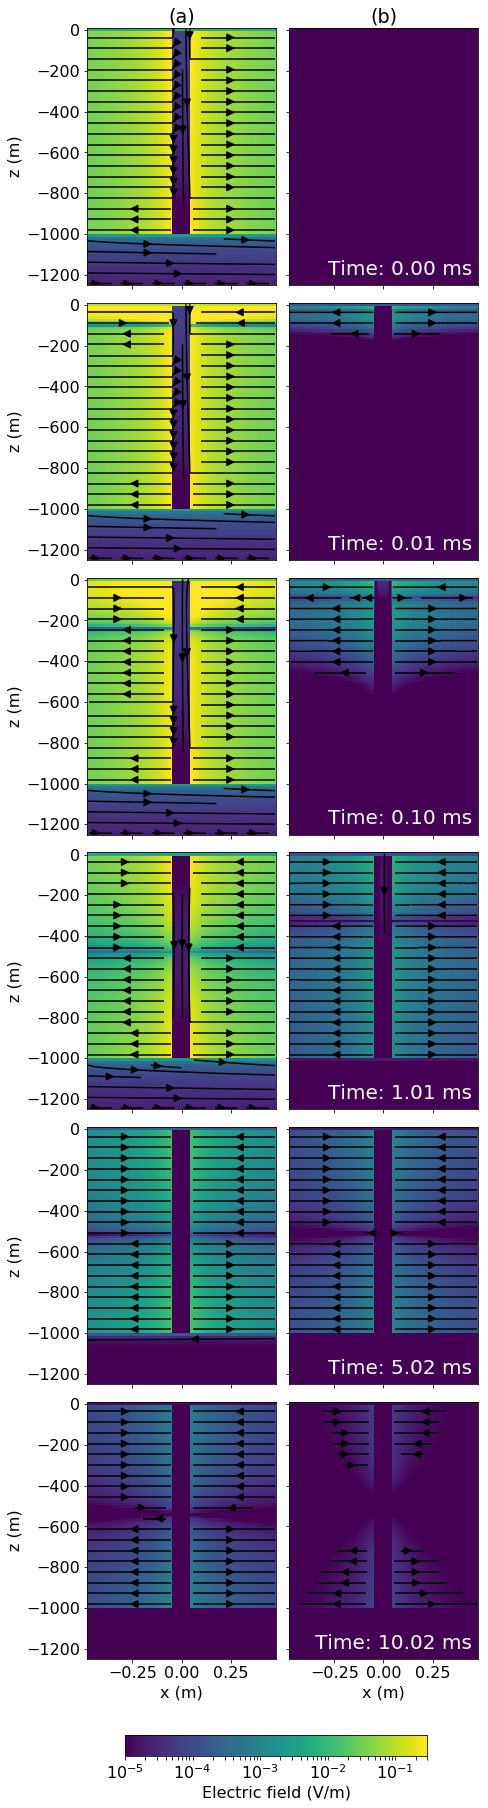

In [89]:
fig, ax = plt.subplots(len(plt_times), 2,  figsize = (7, 5*len(plt_times)))
plt.subplots_adjust(wspace=0.07, hspace=0.07)

rcParams['font.size'] = 16
# rcParams['axes.titlepad'] = 0.5

src_ind = 0

clim_max = 3e-1 
clim_min = 1e-5
clim = np.r_[clim_min, clim_max]

max_depth = 1250
max_r_casing = 0.48
top=10.,

xlim=max_r_casing * np.r_[-1, 1]

x_ticks = [0, -500, -1000, -1500]
stream_opts={"arrowsize":1.6, "color":"k", "density":0.85}

model_key = "approx_casing"
prim_sec = "secondary"

for i, tind in enumerate(plt_times):
    ax0 = ax[i, 0]
    ax1 = ax[i, 1]
    
    # currents in the formation
    out = viewer2.plot_cross_section(
        ax=ax0, clim=clim, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='e', theta_ind=3, time_ind=tind, 
        model_key=model_key, show_cb=False, use_aspect=False,
        stream_opts=stream_opts, prim_sec="primary", src_ind=src_ind
    )
    
    # currents in the formation
    out = viewer2.plot_cross_section(
        ax=ax1, clim=clim, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='e', theta_ind=3, time_ind=tind, 
        model_key=model_key, show_cb=False, use_aspect=False,
        stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
    )
    
#     # currents in the formation
#     out = viewer2.plot_cross_section(
#         ax=ax1, clim=clim_charge, zlim=np.r_[-max_depth, top],
#         xlim=xlim, view='charge_density', theta_ind=3, time_ind=tind, 
#         model_key=model_key, show_cb=False, use_aspect=False,
#         stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
#     )
    ax1.text(0.45, -1200, "Time: {:.2f} ms".format(sim.prob.times[tind]*1e3), color='w', fontsize=20, ha="right")
    
    for a in [ax0, ax1]:
        a.set_title('')
            
        if tind == plt_times[-1]:
            a.set_xlabel('x (m)')
#             a.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        else: 
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            a.set_xlabel('')
        
        if a == ax0:
            a.set_ylabel('z (m)')
        else: 
            a.set_ylabel('')
            a.set_yticklabels(['']*len(a.get_yticklabels()))
        
ax[0, 0].set_title("(a)")
ax[0, 1].set_title("(b)")

cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.01])
cb = plt.colorbar(out[0], cbar_ax, orientation="horizontal")
cb.set_label('Electric field (V/m)')

#         if a == ax1:
#             a.set_ylabel('y (m)', labelpad=0.001)

In [141]:
viewer2.primary_key = "permeable"

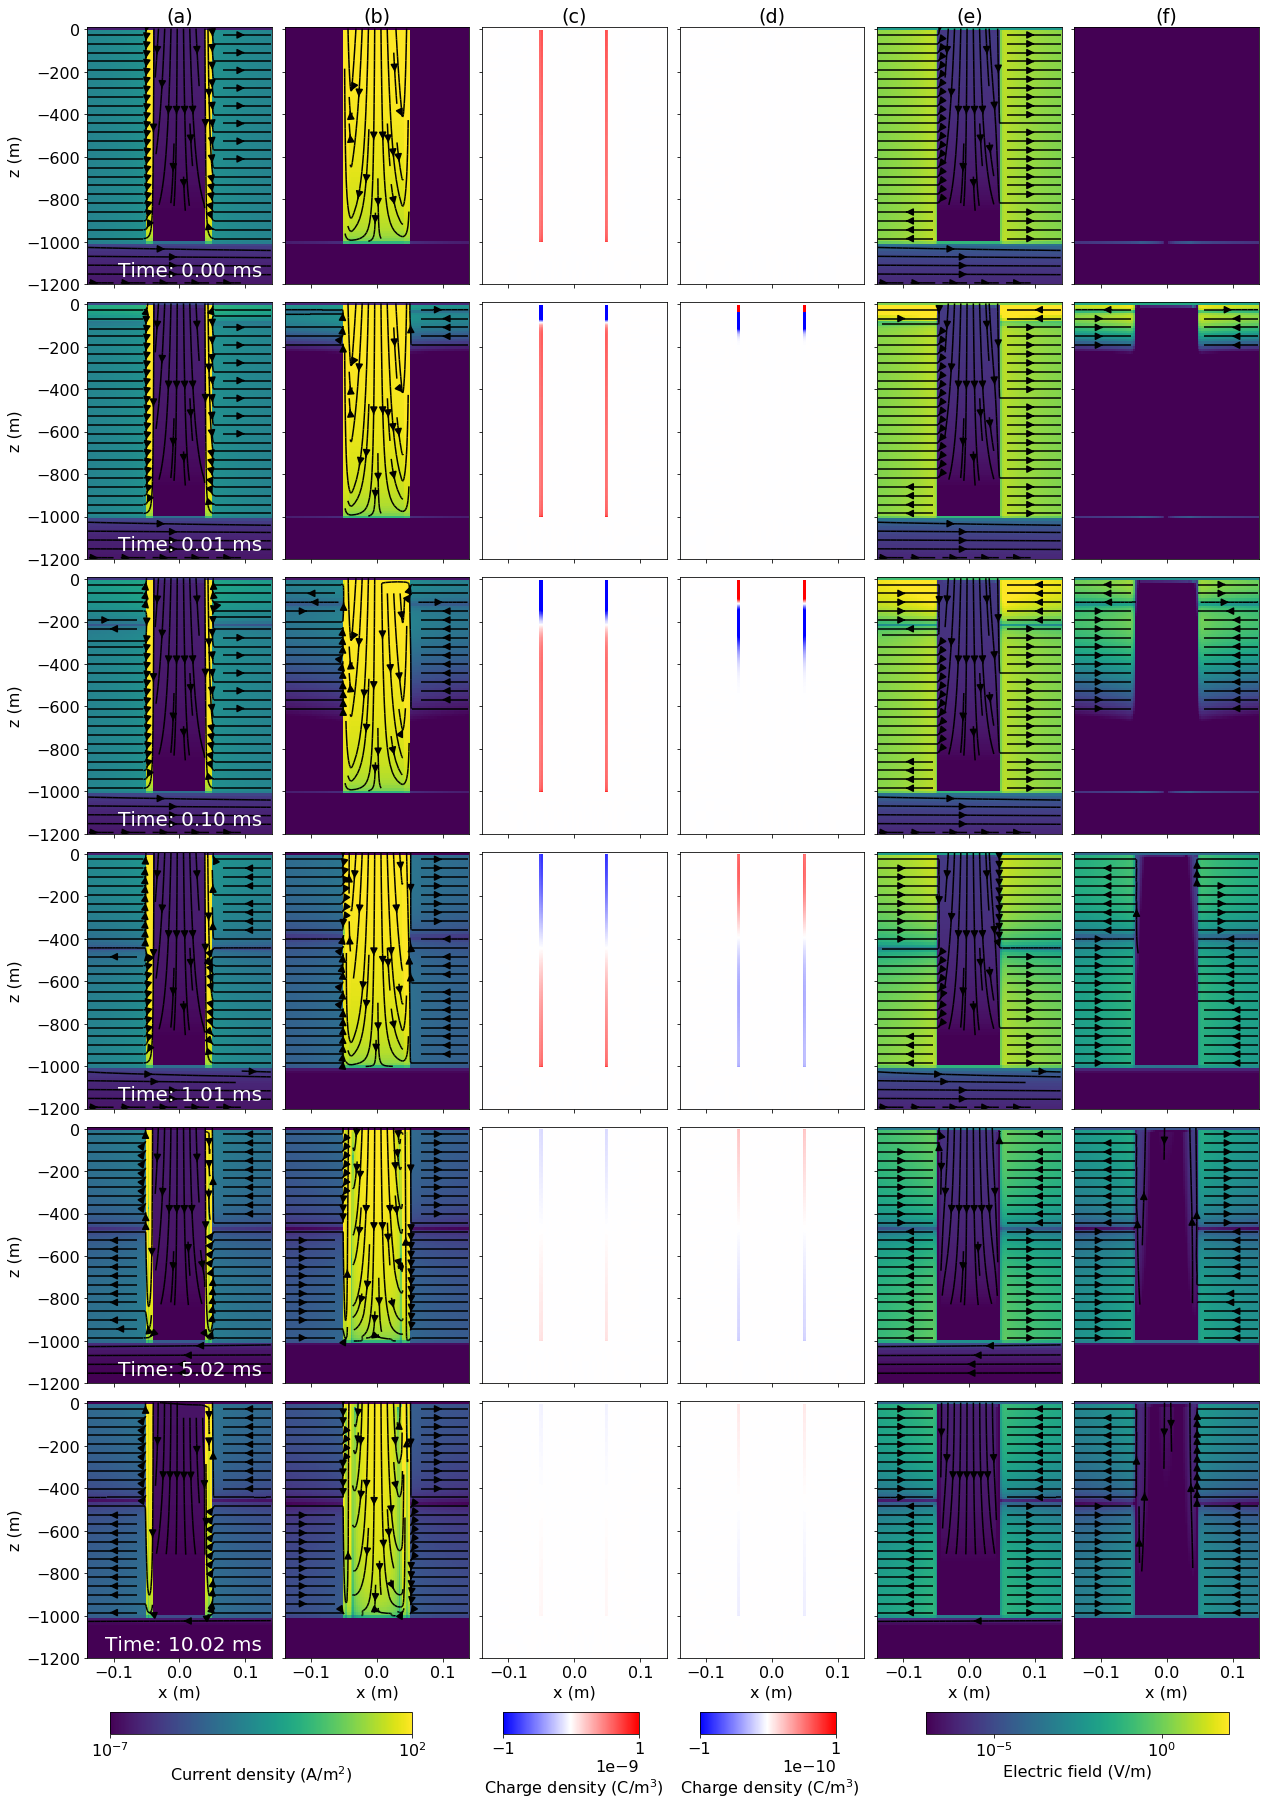

In [142]:
fig, ax = plt.subplots(len(plt_times), 6,  figsize = (3.5*6, 5*len(plt_times)))
plt.subplots_adjust(wspace=0.07, hspace=0.07)

rcParams['font.size'] = 16
# rcParams['axes.titlepad'] = 0.5

src_ind = 0

clim_max = 1 
clim_min = 1e-5
clim = np.r_[clim_min, clim_max]

clim_charge_total = 1e-9*np.r_[-1, 1]

if viewer2.primary_key == "casing":
    clim_charge = 1e-11*np.r_[-1, 1]
else: 
    clim_charge = 1e-10*np.r_[-1, 1]

clim_current = np.r_[1e-7, 1e2]

max_depth = 1200
max_r_casing = 0.14
top=10.,

xlim=max_r_casing * np.r_[-1, 1]

x_ticks = [0, -500, -1000, -1500]
stream_opts={"arrowsize":1.5, "color":"k"}

model_key = "approx_{}".format(viewer2.primary_key) #.split("_")[-1]
prim_sec = "secondary"

for i, tind in enumerate(plt_times):
    ax0 = ax[i, 0]
    ax1 = ax[i, 1]
    ax2 = ax[i, 2]
    ax3 = ax[i, 3]
    ax4 = ax[i, 4]
    ax5 = ax[i, 5]
    
    # currents in the formation
    out_current = viewer2.plot_cross_section(
        ax=ax0, clim=clim_current, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='j', theta_ind=3, time_ind=tind, 
        model_key=model_key, show_cb=False, use_aspect=False,
        stream_opts=stream_opts, prim_sec="primary", src_ind=src_ind
    )
    
    # currents in the formation
    out = viewer2.plot_cross_section(
        ax=ax1, clim=clim_current, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='j', theta_ind=3, time_ind=tind, 
        model_key=model_key, show_cb=False, use_aspect=False,
        stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
    )
    
    # currents in the formation
    out_charge_total = viewer2.plot_cross_section(
        ax=ax2, clim=clim_charge_total, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='charge_density', theta_ind=3, time_ind=tind, 
        model_key=model_key, show_cb=False, use_aspect=False,
        stream_opts=stream_opts, prim_sec="primary", src_ind=src_ind
    )
    
    # currents in the formation
    out_charge = viewer2.plot_cross_section(
        ax=ax3, clim=clim_charge, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='charge_density', theta_ind=3, time_ind=tind, 
        model_key=model_key, show_cb=False, use_aspect=False,
        stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
    )
    
    # currents in the formation
    out_e = viewer2.plot_cross_section(
        ax=ax4, clim=clim, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='e', theta_ind=3, time_ind=tind, 
        model_key=model_key, show_cb=False, use_aspect=False,
        stream_opts=stream_opts, prim_sec="primary", src_ind=src_ind
    )
    
    # currents in the formation
    out = viewer2.plot_cross_section(
        ax=ax5, clim=clim, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='e', theta_ind=3, time_ind=tind, 
        model_key=model_key, show_cb=False, use_aspect=False,
        stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
    )
    
#     # currents in the formation
#     out = viewer2.plot_cross_section(
#         ax=ax1, clim=clim_charge, zlim=np.r_[-max_depth, top],
#         xlim=xlim, view='charge_density', theta_ind=3, time_ind=tind, 
#         model_key=model_key, show_cb=False, use_aspect=False,
#         stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
#     )
    ax0.text(max_r_casing - 0.015, -1160, "Time: {:.2f} ms".format(sim.prob.times[tind]*1e3), color='w', fontsize=20, ha="right")
    
    for a in [ax0, ax1, ax2, ax3, ax4, ax5]:
        a.set_title('')
            
        if tind == plt_times[-1]:
            a.set_xlabel('x (m)')
#             a.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        else: 
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            a.set_xlabel('')
        
        if a == ax0:
            a.set_ylabel('z (m)')
        else: 
            a.set_ylabel('')
            a.set_yticklabels(['']*len(a.get_yticklabels()))

for i, a in enumerate(ax[0, :]):
    a.set_title("({})".format(ascii_lowercase[i]))

cbar_ax = fig.add_axes([0.14, 0.09, 0.2, 0.01])
cb = plt.colorbar(out_current[0], cbar_ax, orientation="horizontal")
cb.set_label('Current density (A/m$^2$)')
cb.set_ticks(clim_current)

cbar_ax = fig.add_axes([0.4, 0.09, 0.09, 0.01])
cb = plt.colorbar(out_charge_total[0], cbar_ax, orientation="horizontal")
cb.set_label('\n Charge density (C/m$^3$)')
cb.set_ticks(clim_charge_total)

cbar_ax = fig.add_axes([0.53, 0.09, 0.09, 0.01])
cb = plt.colorbar(out_charge[0], cbar_ax, orientation="horizontal")
cb.set_label('\n Charge density (C/m$^3$)')
cb.set_ticks(clim_charge)

cbar_ax = fig.add_axes([0.68, 0.09, 0.2, 0.01])
cb = plt.colorbar(out_current[0], cbar_ax, orientation="horizontal")
cb.set_label('Electric field (V/m)')
cb.set_ticks(clim)
# cb.set_ticks([1e1*clim_current[0], 1e-1*clim_current[1]])

#         if a == ax1:
#             a.set_ylabel('y (m)', labelpad=0.001)

In [138]:
fig.savefig("../figures/electric-{}".format(viewer2.primary_key), dpi=250, bbox_inches="tight")

In [71]:
"electric-{}".format(model_key)

'electric-approx_casing'

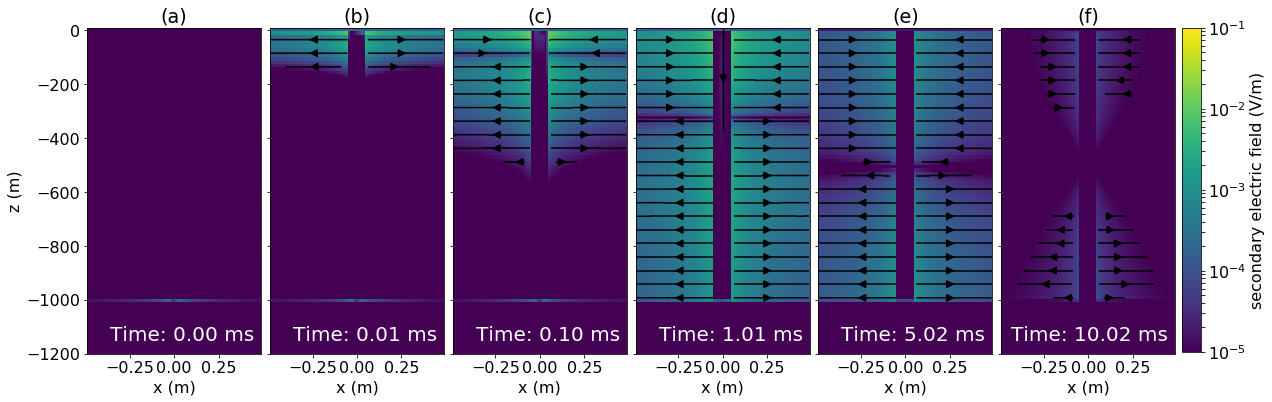

In [127]:
fig, ax = plt.subplots(1, len(plt_times),  figsize = (3.25*len(plt_times), 6))
plt.subplots_adjust(wspace=0.05, hspace=0.07)

rcParams['font.size'] = 16
# rcParams['axes.titlepad'] = 0.5

src_ind = 0

clim_max = 1e-1 
clim_min = 1e-5
clim = np.r_[clim_min, clim_max]

clim_charge = 9e-12*np.r_[-1, 1]

max_depth = 1200
max_r_casing = 0.49
top=10.,

xlim=max_r_casing * np.r_[-1, 1]

x_ticks = [0, -500, -1000, -1500]
# stream_opts={"arrowsize":1.6, "color":"k", "density":0.85}

model_key = "approx_casing"
prim_sec = "secondary"

for i, tind in enumerate(plt_times):
    ax0 = ax[i]
#     ax1 = ax[i, 1]
    
    # currents in the formation
    out = viewer2.plot_cross_section(
        ax=ax0, clim=clim, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='e', theta_ind=3, time_ind=tind, 
        model_key=model_key, show_cb=False, # if i < len(plt_times)-1 else True, 
        use_aspect=False,
        stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
    )
    
    ax0.set_title("({})".format(ascii_lowercase[i]))
    ax0.text(0.45, -1150, "Time: {:.2f} ms".format(sim.prob.times[tind]*1e3), color='w', fontsize=20, ha="right")
    ax0.set_xlabel("x (m)")
#     ax0.set_aspect(1.5e-3)
    if i > 0:
        ax0.set_ylabel('')
        ax0.set_yticklabels(['']*len(a.get_yticklabels()))
    else:
        ax0.set_ylabel('z (m)')
    
cbar_ax = fig.add_axes([0.905, 0.13, 0.013, 0.75])
cb = plt.colorbar(out[0], cbar_ax)
cb.set_label('secondary electric field (V/m)')
#     # currents in the formation
#     out = viewer2.plot_cross_section(
#         ax=ax1, clim=clim_charge, zlim=np.r_[-max_depth, top],
#         xlim=xlim, view='charge_density', theta_ind=3, time_ind=tind, 
#         model_key=model_key, show_cb=False, use_aspect=False,
#         stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
#     )
    
#     for a in [ax0, ax1]:
#         a.set_title('')
            
#         if tind == plt_times[-1]:
#             a.set_xlabel('x (m)')
# #             a.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#         else: 
#             a.set_xticklabels(['']*len(a.get_xticklabels()))
#             a.set_xlabel('')
        
#         if a == ax0:
#             a.set_ylabel('z (m)')
#         else: 
#             a.set_ylabel('')
#             a.set_yticklabels(['']*len(a.get_yticklabels()))
        
            
#         if a == ax1:
#             a.set_ylabel('y (m)', labelpad=0.001)

In [125]:
fig.savefig('../figures/{}-{}-efields'.format(model_key, prim_sec), dpi=250, bbox_inches="tight")